# Import dependencies

In [1]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

In [2]:
# pdb will automatically run on exceptions
#%pdb on # currently not working due to https://github.com/ipython/ipykernel/issues/422

In [3]:
# import os

# # Only occupy one GPU, as in https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# # Only allocate GPU memory as needed
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# # Suppress tf warning messages
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [4]:
%matplotlib inline
from sgm.dependencies import *

# Initialize untrained agent

In [5]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.enable_eager_execution(config=config)

In [6]:
# tf.debugging.set_log_device_placement(True)
tf.test.is_gpu_available()

True

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4735951864108328516
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14360323186994444634
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10990990132
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17742470871881162026
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3e:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 605374146512646328
physical_device_desc: "device: XLA_GPU device"
]


In [8]:
tf.reset_default_graph()

In [9]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent

# If you change the environment parameters below, make sure to run
# tf.reset_default_graph() in the cell above before training.
max_episode_steps = 20
env_name = 'FourRooms'  # Choose one of the environments shown above. 
resize_factor = 5  # Inflate the environment to increase the difficulty.
thin = True # If True, resize by expanding open space, not walls, to make walls thin
desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
model_dir = os.path.join(base_dir, desc_name)

tf_env = env_load_fn(env_name, max_episode_steps,
                     resize_factor=resize_factor,
                     terminate_on_timeout=False,
                     thin=thin)
eval_tf_env = env_load_fn(env_name, max_episode_steps,
                          resize_factor=resize_factor,
                          terminate_on_timeout=True,
                          thin=thin)

agent = UvfAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    max_episode_steps=max_episode_steps,
    use_distributional_rl=True,
    ensemble_size=3)

/home/blbudima/miniconda3/envs/sgm/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Train the agent

In [10]:
# from sgm.trainer import train_eval

# train_eval(agent,
#           tf_env,
#           eval_tf_env,
#           initial_collect_steps=1000,
#           eval_interval=1000,
#           num_eval_episodes=10,
#           num_iterations=30000,
#           save_model_dir=model_dir,
#           experiment_name=f"{env_name}_coordinate_{max_episode_steps}steps")

# Load trained model into agent

In [11]:
filename = "FourRooms_coordinate_20steps-May-09-2021-02-08-19-PM/ckpt/"
checkpoint_file = os.path.join(model_dir, filename)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

# Fill replay buffer with random prefectly explored data

In [12]:
from sgm.envs import *

#@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=0.0,
    min_dist=0,
    max_dist=np.inf)
rb_vec = []
for it in range(replay_buffer_size):
    ts = eval_tf_env.reset()
    rb_vec.append(ts.observation['observation'].numpy()[0])
rb_vec = np.array(rb_vec)

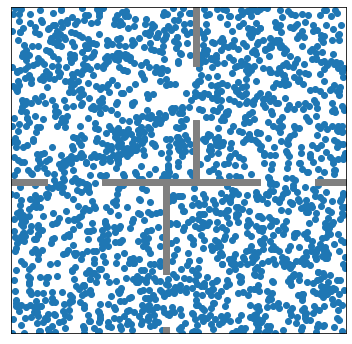

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(*rb_vec.T)
plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
plt.show()

# Calculate qvalue distances

In [14]:
pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()

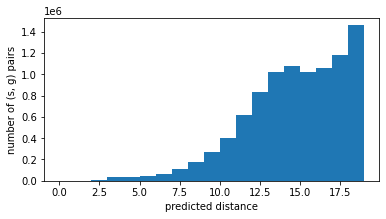

In [15]:
plt.figure(figsize=(6, 3))
plt.hist(pdist.flatten(), bins=range(20))
plt.xlabel('predicted distance')
plt.ylabel('number of (s, g) pairs')
plt.show()

# Tune edge cutoff

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Plotting 223 nodes and 1987 edges


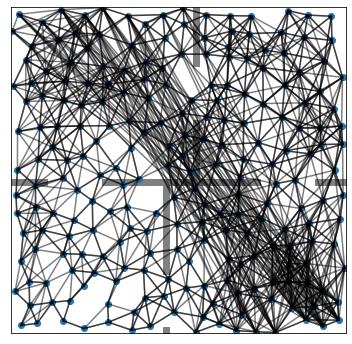

In [16]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=10) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=10)

from sgm.utils.visualization import *
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 1075 edges


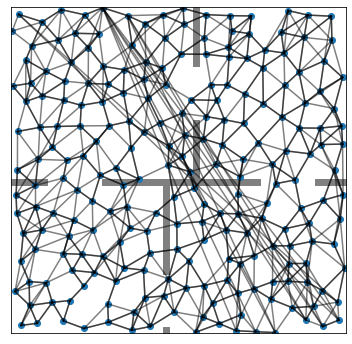

In [17]:
search_policy.keep_k_nearest(5)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 872 edges


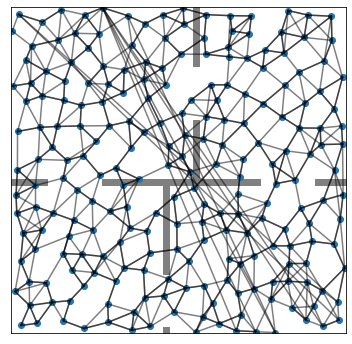

In [18]:
search_policy.keep_k_nearest(4)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 661 edges


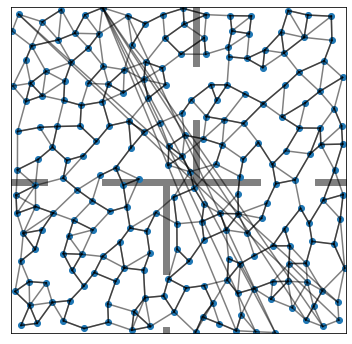

In [19]:
search_policy.keep_k_nearest(3)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 445 edges


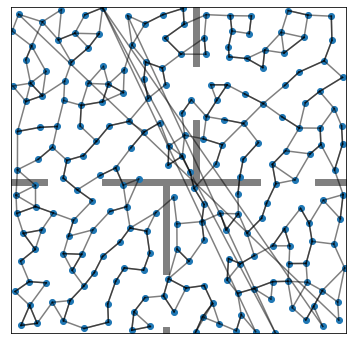

In [20]:
search_policy.keep_k_nearest(2)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 223 edges


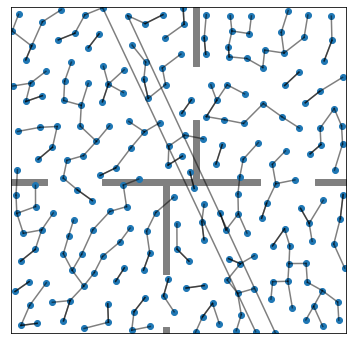

In [21]:
search_policy.keep_k_nearest(1)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

# Calculate Euclidean distances

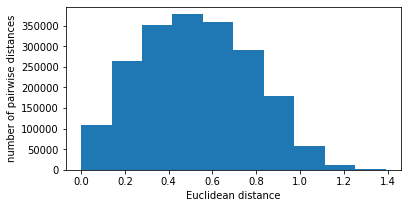

In [22]:
from scipy.spatial import distance
euclidean_dists = distance.pdist(rb_vec)

plt.figure(figsize=(6, 3))
plt.hist(euclidean_dists.flatten())
plt.xlabel('Euclidean distance')
plt.ylabel('number of pairwise distances')
plt.show()

# Initialize SGM search policy

In [23]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=10) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=10)

# Cleanup and evaluate SGM

In [24]:
from sgm.evaluation import cleanup_and_eval

logdir = os.path.join(os.getcwd(), os.pardir, "logs")
eval_difficulty = 0.95
k_nearest = 5
eval_trials = 20
total_cleanup_steps = 50000
eval_period = 5000

logfolder = cleanup_and_eval(search_policy,
                             search_policy_type,
                             desc_name,
                             eval_tf_env,
                             logdir,
                             eval_difficulty=eval_difficulty,
                             k_nearest=k_nearest,
                             eval_trials=eval_trials,
                             total_cleanup_steps=total_cleanup_steps,
                             eval_period=eval_period)

SGM has initial success rate 0.05
Evaluated initial SGM success rate in 508.55 seconds
After filtering and 0 cleanup steps, SGM has success rate 0.00
Took 5000 cleanup steps and evaluated SGM success rate in 1065.25 seconds
After filtering and 5000 cleanup steps, SGM has success rate 0.65
Took 5000 cleanup steps and evaluated SGM success rate in 793.47 seconds
After filtering and 10000 cleanup steps, SGM has success rate 0.80
Took 5000 cleanup steps and evaluated SGM success rate in 691.34 seconds
After filtering and 15000 cleanup steps, SGM has success rate 0.95
Took 5000 cleanup steps and evaluated SGM success rate in 619.69 seconds
After filtering and 20000 cleanup steps, SGM has success rate 0.95
Took 5000 cleanup steps and evaluated SGM success rate in 622.71 seconds
After filtering and 25000 cleanup steps, SGM has success rate 0.80
Took 5000 cleanup steps and evaluated SGM success rate in 656.32 seconds
After filtering and 30000 cleanup steps, SGM has success rate 0.85
Took 5000 

# Load cleanup graphs

In [25]:
from sgm.utils.visualization import *

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_initial"))
initial_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_0_cleanup_steps/"))
filtered_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_{}_cleanup_steps/".format(total_cleanup_steps)))
cleaned_graph = search_policy._g.copy()

pruned_graph = nx.difference(filtered_graph, cleaned_graph)

# Visualize cleanup graphs

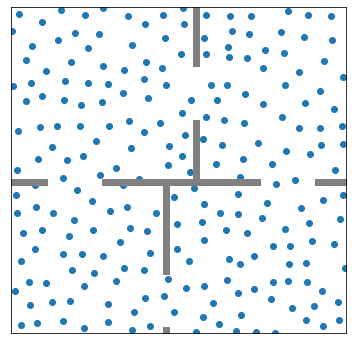

In [26]:
plot_points(search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 1987 edges


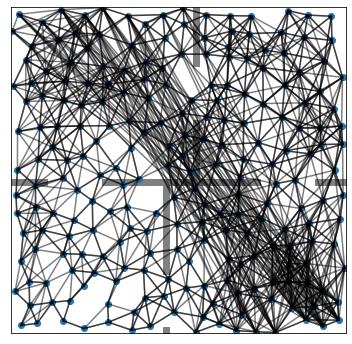

In [27]:
plot_graph(initial_graph, search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 1075 edges


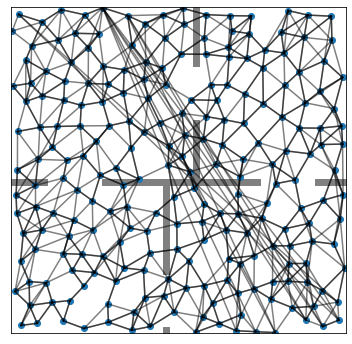

In [28]:
plot_graph(filtered_graph, search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 984 edges


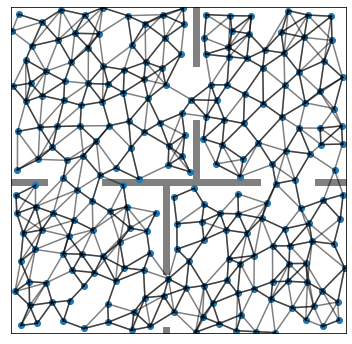

In [29]:
plot_graph(cleaned_graph, search_policy.rb_vec, eval_tf_env)

Plotting 223 nodes and 91 edges


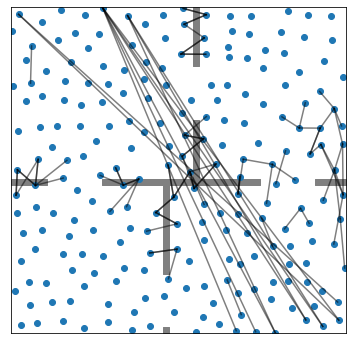

In [30]:
plot_graph(pruned_graph, search_policy.rb_vec, eval_tf_env)